# Описание проекта

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В моем распоряжении данные с параметрами добычи и очистки.


Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.
- **флотация:**
 *Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).*
- **очистка:**
 *Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.*

**Наименование признаков имеет вид:**

[этап].[тип_параметра].[название_параметра]

где: 
**[этап]:**
- `'rougher'` — флотация
- `'primary_cleaner'` — первичная очистка
- `'secondary_cleaner'` — вторичная очистка
- `'final'` — финальные характеристики

**[тип_параметра]:**
- `'input'` — параметры сырья
- `'output'` — параметры продукта
- `'state'` — параметры, характеризующие текущее состояние этапа
- `'calculation'` — расчётные характеристики

**Параметры этапов:**
- `'air amount'` — объём воздуха
- `'fluid levels'` — уровень жидкости
- `'feed size'` — размер гранул сырья
- `'feed rate'` — скорость подачи

**Задача:** Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата `'rougher.output.recovery'`
- эффективность обогащения финального концентрата `'final.output.recovery'`

Итоговая метрика складывается из двух sMAPE: rougher и final

**Цель:** построить модель, предсказывающую коэффициент восстановления золота из золотосодержащей руды

In [1]:
#pip install catboost
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

import warnings
warnings.simplefilter("ignore")

# 1. Подготовка данных

### 1.1. Открытие и изучение файлов

In [2]:
try:
    gold_industry_test = pd.read_csv('gold_industry_test.csv', parse_dates=['date'])
    gold_industry_train = pd.read_csv('gold_industry_train.csv', parse_dates=['date'])
    gold_industry_full = pd.read_csv('gold_industry_full.csv', parse_dates=['date'])
except:
    gold_industry_test = pd.read_csv('/datasets/gold_industry_test.csv', parse_dates=['date'])
    gold_industry_train = pd.read_csv('/datasets/gold_industry_train.csv', parse_dates=['date'])
    gold_industry_full = pd.read_csv('/datasets/gold_industry_full.csv', parse_dates=['date'])

In [3]:
def info(df):
    '''Функция первичного изучения датасетов'''
    print('Размер датасета:', df.shape)
    print('Пропуски в', df.isna().sum()[df.isna().sum() > 0].count(), 'столбцах')
    print('Столбец с максимальным числом пропусков имеет', np.round(df.isna().sum()[df.isna().sum() > 0].max() / df.shape[0] * 100, 2), '% пропусков')
    print('Количество дубликатов в "data":', df['date'].duplicated().sum())
    print('Типы столбцов:\n', df.dtypes.value_counts())
    return df.head()

In [4]:
info(gold_industry_test)

Размер датасета: (4860, 53)
Пропуски в 44 столбцах
Столбец с максимальным числом пропусков имеет 2.59 % пропусков
Количество дубликатов в "data": 0
Типы столбцов:
 float64           52
datetime64[ns]     1
dtype: int64


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


Тестовый датасет `gold_industry_test` состоит 4860 строк и 53 столбцов. В 44 столбцах имеются пропуски. Доля пропусков в стобце с наибольшем их числом не привышает 2.59%. Дубликатов по столбцу `'data'` нет. Все столбцы, кроме `'date'`, имеют тип `float64`. `'date'` - `datetime64`.

In [5]:
info(gold_industry_train)

Размер датасета: (14579, 87)
Пропуски в 39 столбцах
Столбец с максимальным числом пропусков имеет 6.31 % пропусков
Количество дубликатов в "data": 0
Типы столбцов:
 float64           86
datetime64[ns]     1
dtype: int64


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


Обучающий датасет `gold_industry_train` состоит 14579 строк и 87 столбцов. Необходимо в дальнейшем понять, каких столбцов в тестовом датасете нет. В 39 столбцах имеются пропуски. Доля пропусков в стобце с наибольшем их числом не привышает 6.31%. Дубликатов по столбцу `'data'` нет. Все столбцы, кроме `'date',` имеют тип `float64`. `'date'` - `datetime64`.

In [6]:
info(gold_industry_full)

Размер датасета: (19439, 87)
Пропуски в 63 столбцах
Столбец с максимальным числом пропусков имеет 8.99 % пропусков
Количество дубликатов в "data": 0
Типы столбцов:
 float64           86
datetime64[ns]     1
dtype: int64


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


Так как `gold_industry_full` является суммой из тестового и обучающего датасета,  то ожидаемо, что его размер строк равен сумме  двух столбцов - 19439, а количество столбцов как у обучающего - 87 столбцов

### 1.2. Проверяю что эффективность обогащения рассчитана правильно.
Вычисляю её на обучающей выборке для признака `'rougher.output.recovery'`.
Для расчета эффективного обогащиния необходимо знать:
- долю золота в концентрате после флотации (`'rougher.output.concentrate_au'`),
- долю золота в сырье до флотации (`'rougher.input.feed_au'`),
- долю золота в отвальных хвостах после флотации (`'rougher.output.tail_au'`).

In [7]:
gold_industry_train['rougher.output.recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14574    87.684717
14575    90.677361
14576    89.574376
14577    87.724007
14578    88.890579
Name: rougher.output.recovery, Length: 14579, dtype: float64

In [8]:
recovery_cal = gold_industry_train['rougher.output.concentrate_au']*(gold_industry_train['rougher.input.feed_au'] - gold_industry_train['rougher.output.tail_au'])
recovery_cal = recovery_cal * 100 / (gold_industry_train['rougher.input.feed_au']*(gold_industry_train['rougher.output.concentrate_au'] - gold_industry_train['rougher.output.tail_au']))
recovery_cal

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14574    87.684717
14575    90.677361
14576    89.574376
14577    87.724007
14578    88.890579
Length: 14579, dtype: float64

Нахожу среднюю абсолютную ошибку эффективности обогащения между нашей расчетной (`recovery_cal`) и той, что приведена в обучающем датасете. 

In [9]:
print('MAE:', mean_absolute_error(recovery_cal, gold_industry_train['rougher.output.recovery']), '%')

MAE: 1.1181885454685472e-14 %


Средняя абсолютная ошибка почти равна нулю (не ноль из-за округления). То есть можно считать, что эффективность обогащения на этапе флотации в обучающем датасете рассчитано правильно.

### 1.3. Анализ признаков, недоступные в тестовой выборке

In [10]:
# список с названиями колонок, которых нет в тестовой выборке
not_in_test = []
# список с названиями колонок, которые есть в тестовой выборке
in_test = []
[not_in_test.append(col) if col not in list(gold_industry_test.columns) else in_test.append(col) for col in list(gold_industry_train.columns)]
print(len(not_in_test))
not_in_test

34


['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final

В обучающей выборке на 34 столбца больше, чем в тестовой:
- 4, характеризующие расчётные характеристики,
- 34, характеризующие параметры продукта (не известные на момент добычи) на разных этапах добычи.

Таким образом нельзя обучать модель по этим признакам, так как они отсутствуют в обучающем датасете. Далее их устраню, но сначала проведу предобработку данных.

### 1.4. Предобработка данных

Проверю пропуски в обучающей выборке

In [11]:
gold_industry_train.isna().sum()

date                       0
rougher.input.feed_au      0
rougher.input.feed_ag      0
rougher.input.feed_pb     72
rougher.input.feed_sol    77
                          ..
final.output.recovery      0
final.output.tail_au       0
final.output.tail_ag       1
final.output.tail_pb      75
final.output.tail_sol      5
Length: 87, dtype: int64

Известно, что данные индексируются датой и временем получения информации (признак `'date'`). Соседние по времени параметры часто похожи. Поэтому заполню пропуски методом `'ffill'`, которые заполняются предыдущими значениями.

In [12]:
gold_industry_train = gold_industry_train.fillna(method='ffill')
gold_industry_train.isna().sum().sum()

0

Посмотрю на выбросы составляющих смеси золотоносной руды.

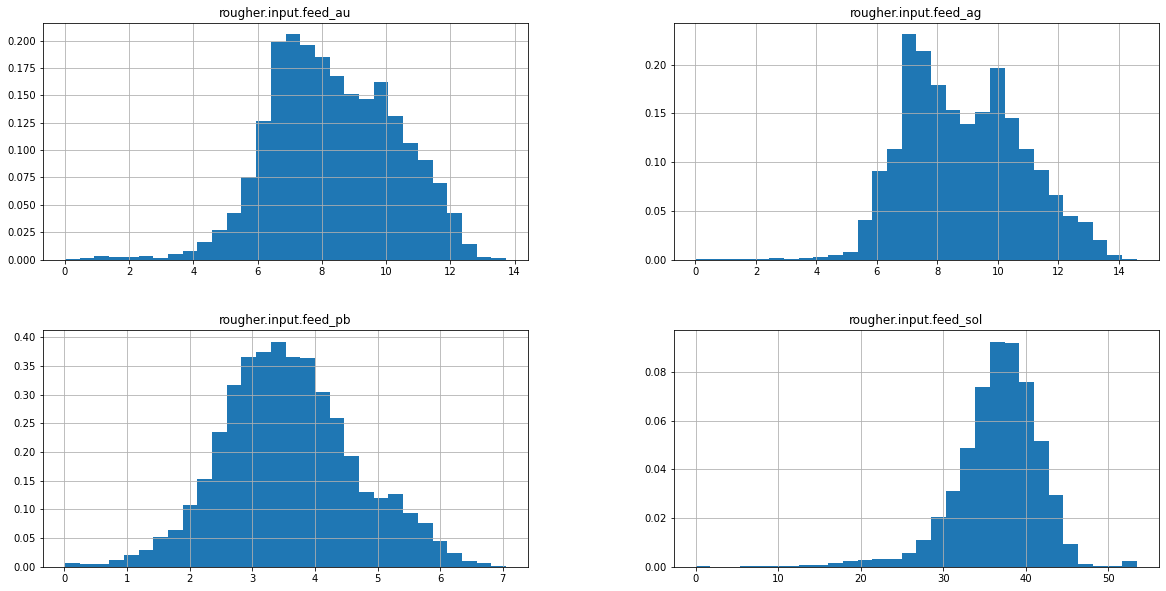

In [13]:
gold_industry_train[in_test[1:5]].hist(figsize=(20, 10), bins=30, density=True);

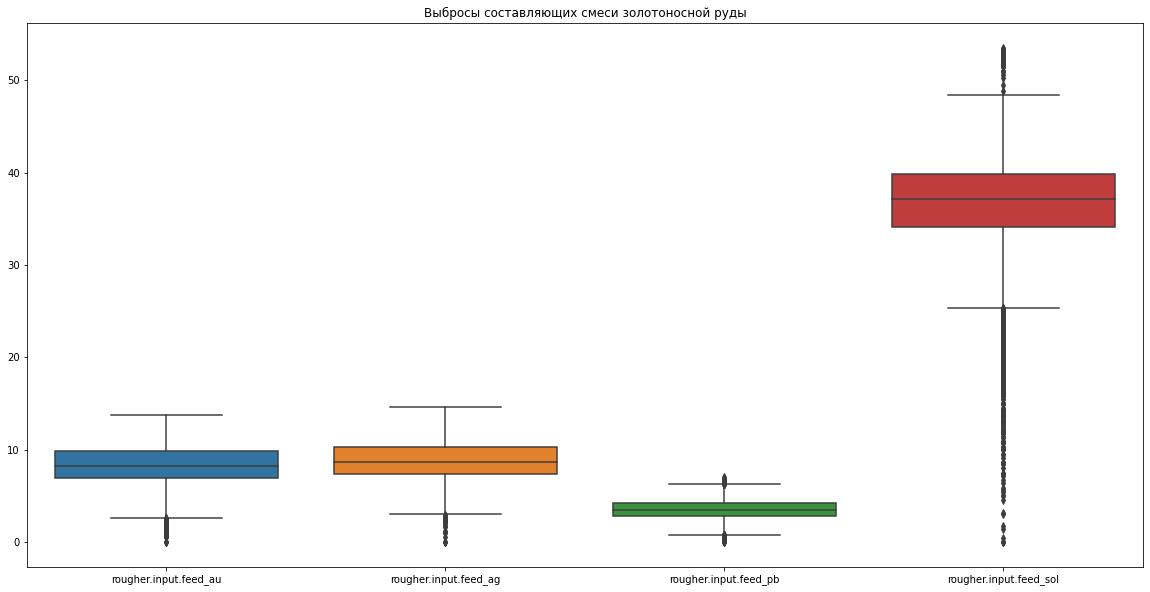

In [14]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=gold_industry_train[in_test[1:5]])
plt.title('Выбросы составляющих смеси золотоносной руды');

Имеются много выбрасов в концентрациях золота, серебра, свинца и других металлов. Очищу их только на обучающем датасете.

In [15]:
gold_industry_train.shape

(14579, 87)

In [16]:
def whiskers_min(df):
    '''Функция определния нижней границы выбросов'''
    df_min = df.quantile(0.25) - 1.5 * (df.quantile(0.75) - df.quantile(0.25))
    return df_min
def whiskers_max(df):
    '''Функция определния верхней границы выбросов'''
    df_max = df.quantile(0.75) + 1.5 * (df.quantile(0.75) - df.quantile(0.25))
    return df_max

for u in in_test[1:5]:
    gold_industry_train = gold_industry_train[(whiskers_min(gold_industry_train[u]) < gold_industry_train[u]) & (whiskers_max(gold_industry_train[u]) > gold_industry_train[u])]

In [17]:
gold_industry_train.shape

(13871, 87)

Очистил 5.43% обучающей выборки.

# 2. Анализ данных

Посмотрю, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

In [18]:
au_ag_pb = pd.DataFrame({'rougher.input.feed' : gold_industry_train[in_test[1:4]].mean().values,
              'rougher.output.concentrate' : gold_industry_train[not_in_test[4:7]].mean().values,
              'rougher.output.tail' : gold_industry_train[not_in_test[9:12]].mean().values,
              'primary_cleaner.output.concentrate' : gold_industry_train[not_in_test[13:16]].mean().values,
              'primary_cleaner.output.tail' : gold_industry_train[not_in_test[17:20]].mean().values,
              'secondary_cleaner.output.tail' : gold_industry_train[not_in_test[21:24]].mean().values,
              'final.output.concentrate' : gold_industry_train[not_in_test[25:28]].mean().values,
              'final.output.tail' : gold_industry_train[not_in_test[30:33]].mean().values},
              index = ['au', 'ag', 'pb'])
au_ag_pb

,rougher.input.feed,rougher.output.concentrate,rougher.output.tail,primary_cleaner.output.concentrate,primary_cleaner.output.tail,secondary_cleaner.output.tail,final.output.concentrate,final.output.tail
au,8.430337,19.756371,1.850035,32.138840,3.958954,4.351665,44.185627,3.095065
ag,8.930708,11.951774,5.653833,8.520356,16.074837,14.480986,5.198665,9.741639
pb,3.629634,7.547887,0.657524,9.831757,3.406007,5.641948,9.987386,2.726567


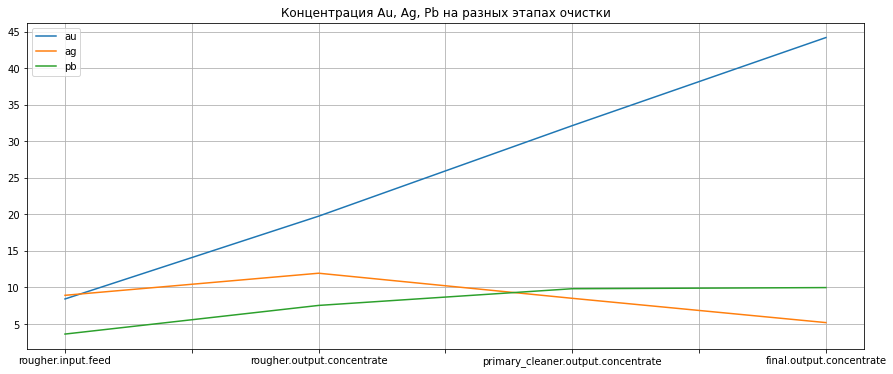

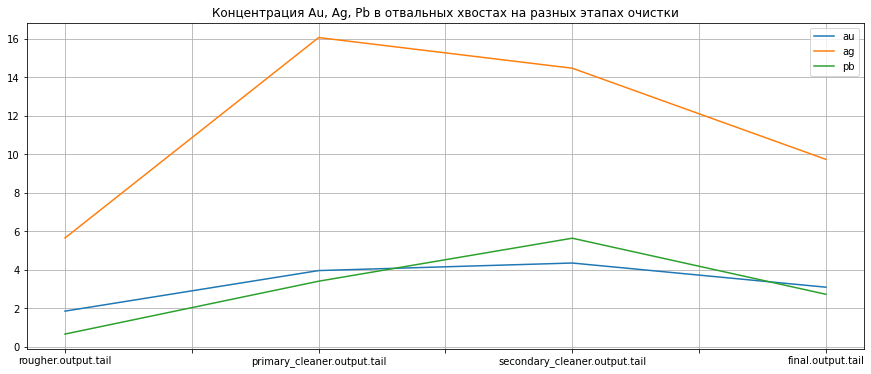

In [19]:
au_ag_pb[['rougher.input.feed',
          'rougher.output.concentrate',
          'primary_cleaner.output.concentrate',
          'final.output.concentrate']].T.plot(figsize=(15, 6), grid=True,
                                              title='Концентрация Au, Ag, Pb на разных этапах очистки');

au_ag_pb[['rougher.output.tail',
          'primary_cleaner.output.tail',
          'secondary_cleaner.output.tail',
          'final.output.tail']].T.plot(figsize=(15, 6), grid=True,
                                       title='Концентрация Au, Ag, Pb в отвальных хвостах на разных этапах очистки');

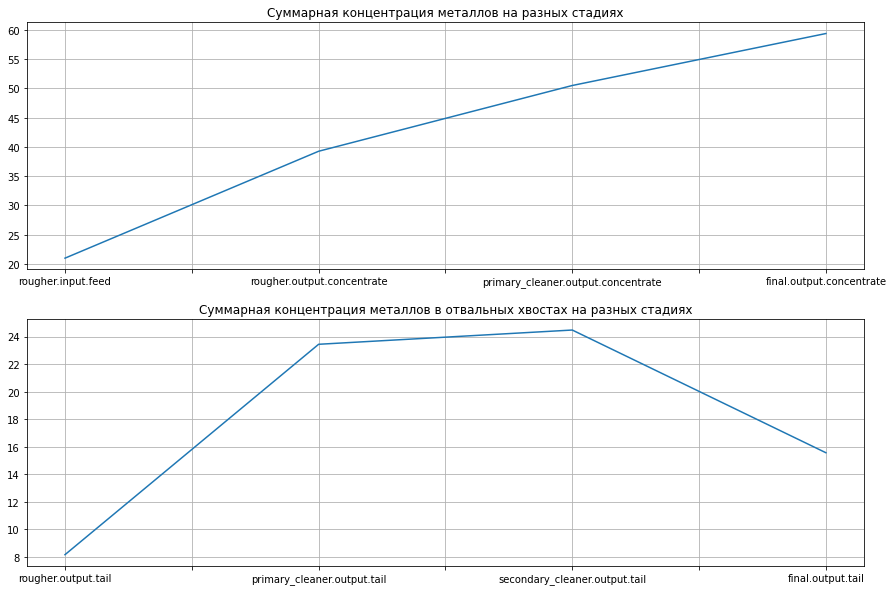

In [20]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
au_ag_pb.sum()[['rougher.input.feed',
                'rougher.output.concentrate',
                'primary_cleaner.output.concentrate',
                'final.output.concentrate']].plot(grid=True,
                                              title='Cуммарная концентрация металлов на разных стадиях');
plt.subplot(2, 1, 2)
au_ag_pb.sum()[['rougher.output.tail',
                'primary_cleaner.output.tail',
                'secondary_cleaner.output.tail',
                'final.output.tail']].plot(grid=True,
                                              title='Cуммарная концентрация металлов в отвальных хвостах на разных стадиях');

Концентрация золота линейно возрастает после каждого этапа очистки. Концентрация серебра (Ag) возрастает после флотации, а далее падает из-за того, что элемент усиленно начинает вымываться и уходить с отвальными хвостами, начиная с первичной очистки. В финальном концентрате серебра почти в 2 раза меньше, чем в исходном сырье. Концентрация свинца монотонно растет на каждом этапе, несмотря на то, что и вымывается его с каждым этапом больше.

Суммарная концентрация металлов Au, Ag, Pb увеличивается на кажом этапе отистки руды. В отвальных хвостах суммарная концентрация увеличивается ко второму этапу очистки. Однако финальная концентрация падает. Это может произойти из-за того, что отвальные хвосты после каждого этапа смешиваются в общем коллекторе, и финальная концентрация - рузельтат смешения.

Несмотря на увеличение концентрации золота почти в 5 раз за весь цикл, технология не совершенна, так как в отвальных хвостах также растет концентрация золота. Особенно на первом и втором этапе очистки. Теоретически, сам финальный отвальный хвост можно подать на вход флотационной установки и дополнительно его очистить, уменьшив потери золота и увеличив эффективность всего процесса.

Сравню распределения размеров гранул исходного сырья на обучающей и тестовой выборках.

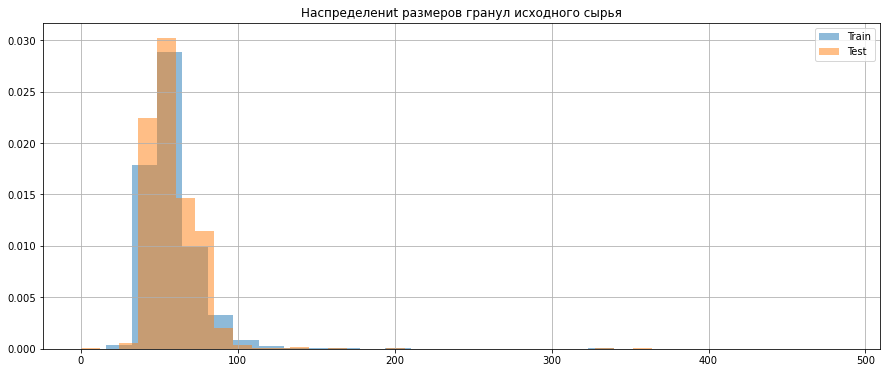

In [21]:
plt.figure(figsize=(15, 6))
gold_industry_train['rougher.input.feed_size'].hist(density=True, bins=30, alpha=0.5, label='Train')
gold_industry_test['rougher.input.feed_size'].hist(density=True, bins=30, alpha=0.5, label='Test')
plt.title('Hаспределениt размеров гранул исходного сырья')
plt.legend();

Распределения не сильно отличаются друг от друга. Эта значит, что могу применять обученную модель на тестовых данных, и оценка модели не будет неправильной

In [22]:
pd.DataFrame({'train' : gold_industry_train['rougher.input.feed_size'],
              'test' : gold_industry_test['rougher.input.feed_size']}).describe()

,train,test
count,13871.000000,4816.000000
mean,58.532147,59.113400
std,20.419170,19.125122
min,0.049194,0.046369
25%,47.399737,47.596984
50%,54.356317,55.509481
75%,63.985271,66.661547
max,484.967466,363.989699


# 3. Построение модели

Необходимо предсказать две целевые переменные:
- эффективность обогащения чернового концентрата `'rougher.output.recovery'`;
- эффективность обогащения финального концентрата `'final.output.recovery'`.

Предсказывать `'rougher.output.recovery'` буду только по этапу флотации, используя типы параметров `input` и `state`, которые есть в тестовой выборке.

Предсказывать `'final.output.recovery'` буду по всем этапам вместе взятым, используя типы параметров `input` и `state`, которые есть в тестовой выборке.

In [23]:
in_test

['date',
 'rougher.input.feed_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 '

Пропуски в обучающей выборке заполнил раннее методом `'ffill'`. В тестовой выборке достаточно удалить пропуски вообще

In [24]:
gold_industry_test.isna().sum()

date                                            0
rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air                 7
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0


In [25]:
gold_industry_test = gold_industry_test.dropna()

In [26]:
gold_industry_test.isna().sum().sum()

0

In [27]:
gold_industry_test.shape

(4537, 53)

Удалил 6.64% пропусков в обучающей выборке.

Разобъю наши выборки на обучающие и тестовые признаки и таргеты для двух случаев. Также найду целевую переменную для тестовой выборки из датасета `gold_industry_full`, сопоставляя даты признаков и таргета. Так как не исследую зависимость эффективности обогащения от времени, а оно используется лишь для маркировки сбора данных, то можно смело удалить признак `'date'`.

In [28]:
X_rougher_train = gold_industry_train[in_test[1:23]]
X_rougher_test = gold_industry_test[in_test[1:23]]

X_final_train = gold_industry_train[in_test].drop(columns=['date'], axis=1)
X_final_test = gold_industry_test[in_test].drop(columns=['date'], axis=1)

y_rougher_test = gold_industry_full.set_index('date').loc[gold_industry_test['date'].values, 'rougher.output.recovery']
y_final_test = gold_industry_full.set_index('date').loc[gold_industry_test['date'].values, 'final.output.recovery']

y_rougher_train = gold_industry_train.loc[X_rougher_train.index, 'rougher.output.recovery']
y_final_train = gold_industry_train.loc[X_final_train.index, 'final.output.recovery']

In [29]:
print('Размер признаков обучающей выборки флотации:', X_rougher_train.shape)
print('Размер признаков обучающей выборки всего цикла очистки:', X_final_train.shape)

Размер признаков обучающей выборки флотации: (13871, 22)
Размер признаков обучающей выборки всего цикла очистки: (13871, 52)


In [30]:
if X_final_test.shape[0] == y_final_test.shape[0]:
    print('Размер тестовых признаков и таргета флотации совпадает')
else:
    print('Ахтунг! Размер тестовых признаков и таргета флотации НЕ совпадает')

if X_rougher_test.shape[0] == y_rougher_test.shape[0]:
    print('Размер тестовых признаков и таргета всего цикла очистки совпадает')
else:
    print('Ахтунг! Размер тестовых признаков и таргета всего цикла очистки НЕ совпадает')
    
if X_final_train.shape[0] == y_final_train.shape[0]:
    print('Размер обучающих признаков и таргета флотации совпадает')
else:
    print('Ахтунг! Размер тестовых признаков и таргета флотации НЕ совпадает')

if X_rougher_train.shape[0] == y_rougher_train.shape[0]:
    print('Размер обучающих признаков и таргета всего цикла очистки совпадает')
else:
    print('Ахтунг! Размер тестовых признаков и таргета всего цикла очистки НЕ совпадает')

Размер тестовых признаков и таргета флотации совпадает
Размер тестовых признаков и таргета всего цикла очистки совпадает
Размер обучающих признаков и таргета флотации совпадает
Размер обучающих признаков и таргета всего цикла очистки совпадает


In [31]:
print('Количество пропусков в выборке флотации:', y_rougher_test.isna().sum())
print('Количество пропусков в выборке всего цикла очистки:', y_final_test.isna().sum())

Количество пропусков в выборке флотации: 0
Количество пропусков в выборке всего цикла очистки: 0


Исследую мультиколлинеарность линейной корреляцией Пирсона.

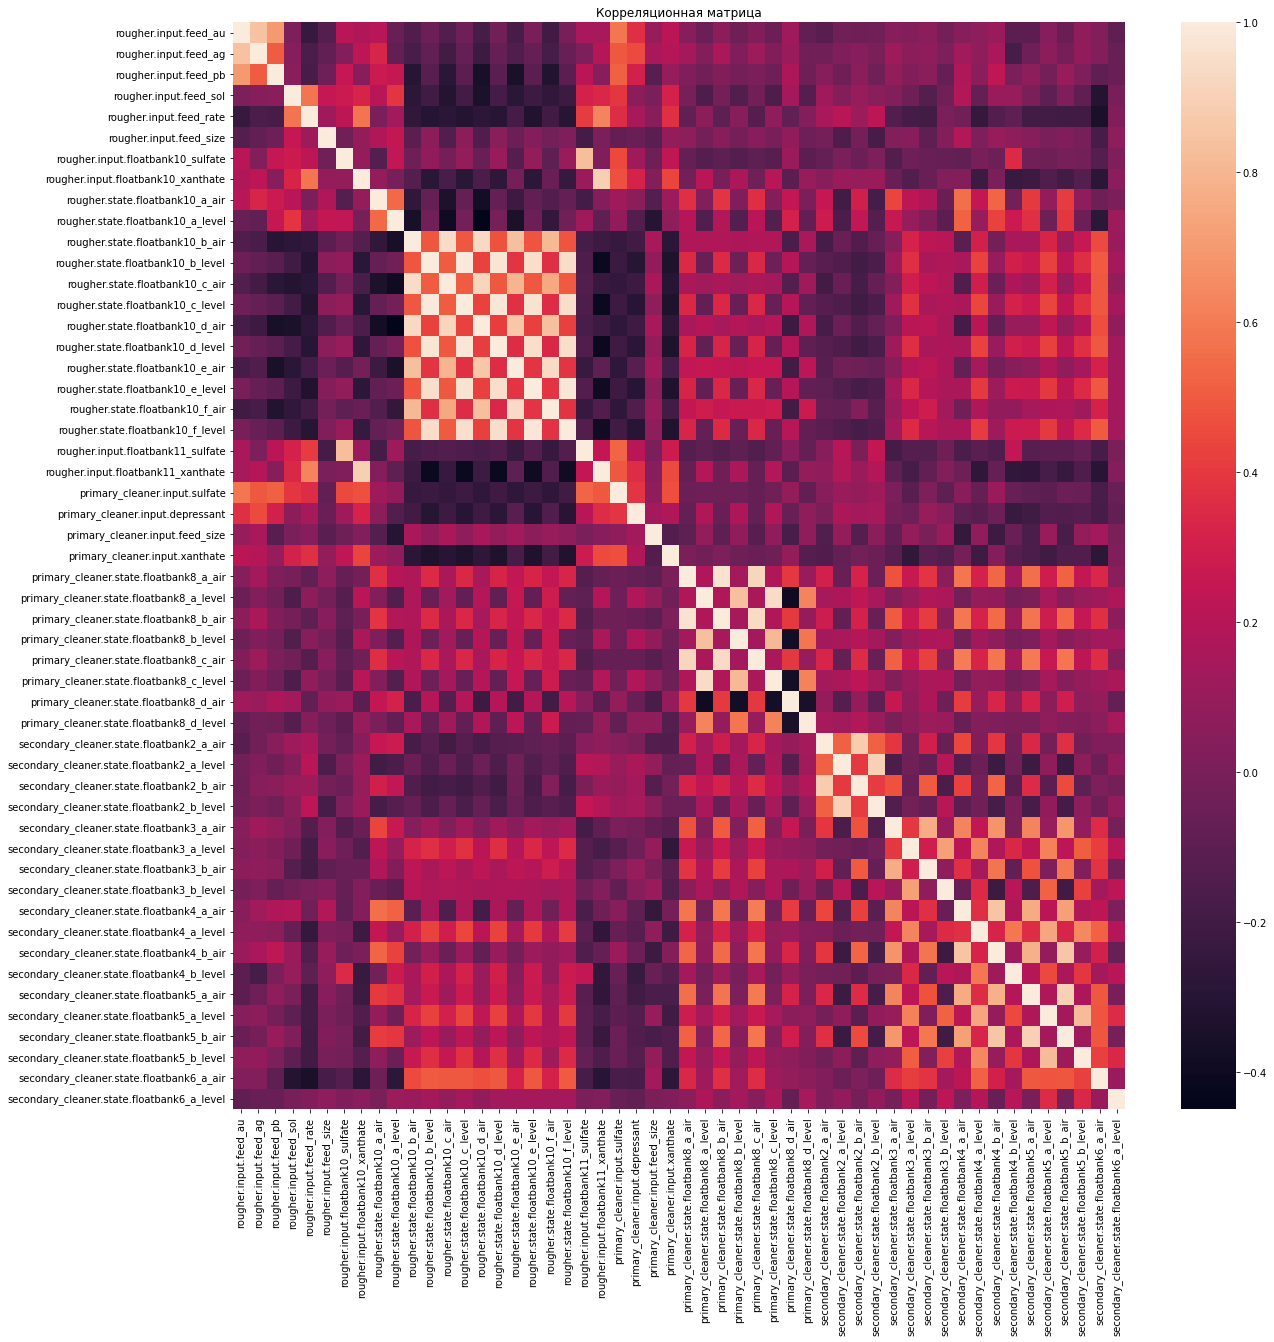

In [32]:
plt.figure(figsize=(20, 20))
sns.heatmap(X_final_train.corr())
plt.title('Корреляционная матрица');

Столбцы с `'rougher.state.floatbank10_b_air'` по `'rougher.state.floatbank10_f_level'` через сильно линейно коррелируют между собой. Аналогично у диапазона признаков `'primary_cleaner.state.floatbank8_a_air'`-`'primary_cleaner.state.floatbank8_c_air'` и `'secondary_cleaner.state.floatbank2_a_air'`-`'secondary_cleaner.state.floatbank2_b_air'`. Исключу данные столбцы.

In [33]:
X_rougher_train = X_rougher_train.drop(columns=in_test[11:21], axis=1)
X_rougher_test = X_rougher_test.drop(columns=in_test[11:21], axis=1)
X_final_train = X_final_train.drop(columns=(in_test[11:21]+in_test[27:33]+in_test[35:39]), axis=1)
X_final_test = X_final_test.drop(columns=(in_test[11:21]+in_test[27:33]+in_test[35:39]), axis=1)

Отмасштабирую признаки

In [34]:
scaler_rougher = StandardScaler()
scaler_rougher.fit(X_rougher_train)
X_rougher_train = scaler_rougher.transform(X_rougher_train)
X_rougher_test = scaler_rougher.transform(X_rougher_test)

scaler_final = StandardScaler()
scaler_final.fit(X_final_train)
X_final_train = scaler_final.transform(X_final_train)
X_final_test = scaler_final.transform(X_final_test)

### 3.1. Функция для вычисления итоговой sMAPE

In [35]:
def smape(predict, y_true):
    '''Функция вычисления sMAPE.
    На входе принимает предсказание и таргет.
    На выходе - оценка'''
    smape = abs(y_true - predict)*2 / (abs(y_true) + abs(predict))
    smape = smape.sum() / len(predict)
    smape = smape * 100
    return np.round(smape, 2)

def general_smape(smape_rougher, smape_final):
    '''Функция вычисления комбинированного sMAPE.
    На входе принимает sMAPE флотации и sMAPE всего цикла очистки.
    На выходе - комбинированная sMAPE'''
    gen_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return np.round(gen_smape, 2)

### 3.2. Обучение модели

Буду рассматривать три модели регрессии для каждого случая (флотация и полный цикл очистки):
- линейная регрессия,
- дерево решений,
- случайный лес,
- градиентный бустинг.

Оценивать гиперпараметры буду с помощью кроссвалидации, которая уже встроена в GridSearchCV (для случайного леса RandomizedSearchCV). Качество кросс-валидации определяю пользовательской метрикой sMAPE через `make_scorer`. Для линейной же регрессии воспользуюсь `cross_val_score`. Далее, по лучшим гиперпараметрам найду предсказания, сравню его таргетом той же sMAPE, а после по наименьшим sMAPE найду общую комбинированную sMAPE.

In [36]:
def grid_search(model, param, X_train, y_train):
    '''Функция подбора гиперпараметров с помощью GridSearchCV.
       На входе принимает модель, словарь с гиперпараметрами, фичи и таргет.
       На выходе - оценка кроссвалидации и словарь с лучшими гиперпараметрами'''
    
    grid = GridSearchCV(model, param, n_jobs=-1, cv=5, scoring=make_scorer(smape, greater_is_better=False))
    grid.fit(X_train, y_train)
    print('Средняя sMAPE кросс-валидации:', -grid.best_score_)
    return -grid.best_score_, grid.best_params_

def grid_search_random(model, param, X_train, y_train):
    '''Функция подбора гиперпараметров с помощью RandomizedGridSearchCV.
       На входе принимает модель, словарь с гиперпараметрами, фичи и таргет.
       На выходе - оценка кроссвалидации и словарь с лучшими гиперпараметрами'''
    
    grid = RandomizedSearchCV(model, param, n_jobs=-1, cv=5, scoring=make_scorer(smape, greater_is_better=False))
    grid.fit(X_train, y_train)
    print('Средняя sMAPE кросс-валидации:', -grid.best_score_)
    return -grid.best_score_, grid.best_params_

def linear_regression(X_train, y_train, X_test, y_test):
    '''Функция линейной регрессии.
       На входе принимает фичи и таргеты обучающей и тестовой выборок.
       На выходе - оценка кроссвалидации и оценка sMAPE'''
    print('=============== линейная регрессия ===============')
    clf = LinearRegression()
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=make_scorer(smape, greater_is_better=False))
    print('Средняя sMAPE кросс-валидации:', -scores.mean())
    clf.fit(X_train, y_train)
    print('Оценка sMAPE на обучающей выборке:', smape(clf.predict(X_train), y_train))
    predict = clf.predict(X_test)
    return -scores.mean(), smape(predict, y_test)

def lasso(X_train, y_train, X_test, y_test, param):
    '''Функция Лассо-регрессии.
       На входе принимает фичи и таргеты обучающей и тестовой выборок.
       На выходе - оценка кроссвалидации и оценка sMAPE'''
    print('=============== лассо-регрессия ===============')
    clf = Lasso(random_state=12345)
    score, alpha_ = grid_search(clf, param, X_train, y_train)
    clf = Lasso(alpha=alpha_['alpha'], random_state=12345)
    clf.fit(X_train, y_train)
    print('Оценка sMAPE на обучающей выборке:', smape(clf.predict(X_train), y_train))
    predict = clf.predict(X_test)
    return score, smape(predict, y_test)

def decision_tree(X_train, y_train, X_test, y_test, param):
    '''Функция решающего дерева.
       На входе принимает фичи и таргеты обучающей и тестовой выборок.
       На выходе - оценка кроссвалидации и оценка sMAPE'''
    print('=============== дерево решений ===============')
    clf = DecisionTreeRegressor(random_state=12345)
    score, m = grid_search(clf, param, X_train, y_train)
    clf = DecisionTreeRegressor(random_state=12345,
                                max_depth=m['max_depth'],
                                min_samples_split=m['min_samples_split'],
                                min_samples_leaf=m['min_samples_leaf'])
    clf.fit(X_train, y_train)
    print('Оценка sMAPE на обучающей выборке:', smape(clf.predict(X_train), y_train))
    predict = clf.predict(X_test)
    return score, smape(predict, y_test)

def random_forest_tree(X_train, y_train, X_test, y_test, param):
    '''Функция случайного леса.
       На входе принимает фичи и таргеты обучающей и тестовой выборок.
       На выходе - оценка кроссвалидации и оценка sMAPE'''
    print('=============== случайный лес ===============')
    clf = RandomForestRegressor(random_state=12345)
    score, m = grid_search_random(clf, param, X_train, y_train)
    clf = RandomForestRegressor(random_state=12345,
                                n_estimators=m['n_estimators'],
                                max_depth=m['max_depth'],
                                min_samples_split=m['min_samples_split'],
                                min_samples_leaf=m['min_samples_leaf'])
    clf.fit(X_train, y_train)
    print('Оценка sMAPE на обучающей выборке:', smape(clf.predict(X_train), y_train))
    predict = clf.predict(X_test)
    return score, smape(predict, y_test)

def cat_boost(X_train, y_train, X_test, y_test, param):
    '''Функция градиентного бустинга.
       На входе принимает фичи и таргеты обучающей и тестовой выборок.
       На выходе - оценка кроссвалидации и оценка sMAPE'''
    print('=============== градиентный бустинг ===============')
    clf = CatBoostRegressor(random_state=12345, verbose=False)
    score, m = grid_search_random(clf, param, X_train, y_train)
    clf = CatBoostRegressor(random_state=12345,
                            verbose=False,
                            iterations=m['iterations'],
                            depth=m['depth'],
                            l2_leaf_reg=m['l2_leaf_reg'])
    clf.fit(X_train, y_train)
    print('Оценка sMAPE на обучающей выборке:', smape(clf.predict(X_train), y_train))
    predict = clf.predict(X_test)
    return score, smape(predict, y_test)

In [37]:
s_rougher_linear, smape_rougher_linear = linear_regression(X_rougher_train, y_rougher_train, X_rougher_test, y_rougher_test)
# print('Оценка sMAPE:', s_rougher_linear)
s_final_linear, smape_final_linear = linear_regression(X_final_train, y_final_train, X_final_test, y_final_test)
# print('Оценка sMAPE:', s_final_linear)

=============== линейная регрессия ===============
Средняя sMAPE кросс-валидации: 12.29
Оценка sMAPE на обучающей выборке: 11.48
=============== линейная регрессия ===============
Средняя sMAPE кросс-валидации: 10.459999999999999
Оценка sMAPE на обучающей выборке: 8.86


In [38]:
s_rougher_lasso, smape_rougher_lasso = lasso(X_rougher_train, y_rougher_train, X_rougher_test, y_rougher_test, {'alpha' : arange(0, 1, 0.01)})
# print('Оценка sMAPE:', s_rougher_lasso)
s_final_lasso, smape_final_lasso = lasso(X_final_train, y_final_train, X_final_test, y_final_test, {'alpha' : arange(0, 1, 0.01)})
# print('Оценка sMAPE:', s_final_lasso)

=============== лассо-регрессия ===============
Средняя sMAPE кросс-валидации: 12.026
Оценка sMAPE на обучающей выборке: 11.42
=============== лассо-регрессия ===============
Средняя sMAPE кросс-валидации: 9.604
Оценка sMAPE на обучающей выборке: 9.02


In [39]:
s_rougher_decision_tree, smape_rougher_decision_tree = decision_tree(X_rougher_train, y_rougher_train, X_rougher_test, 
                                                                     y_rougher_test,
                                                                    {'max_depth' : range(1, 11),
                                                                     'min_samples_split' : range(2, 11, 2),
                                                                     'min_samples_leaf' : range(1, 11, 2)})
# print('Оценка sMAPE:', s_rougher_decision_tree)
s_final_decision_tree, smape_final_decision_tree = decision_tree(X_final_train, y_final_train, X_final_test, y_final_test, 
                                                                {'max_depth' : range(1, 11),
                                                                 'min_samples_split' : range(2, 11, 2),
                                                                 'min_samples_leaf' : range(1, 11, 2)})
# print('Оценка sMAPE:', s_final_decision_tree)

=============== дерево решений ===============
Средняя sMAPE кросс-валидации: 12.436
Оценка sMAPE на обучающей выборке: 11.49
=============== дерево решений ===============
Средняя sMAPE кросс-валидации: 10.006
Оценка sMAPE на обучающей выборке: 9.24


In [40]:
s_rougher_random_forest, smape_rougher_random_forest = random_forest_tree(X_rougher_train, y_rougher_train, 
                                                                          X_rougher_test, y_rougher_test, 
                                                                         {'n_estimators' : range(1, 101, 20),
                                                                          'max_depth' : range(1, 11),
                                                                          'min_samples_split' : range(2, 11, 2),
                                                                          'min_samples_leaf' : range(1, 11, 2)})
# print('Оценка sMAPE:', s_rougher_random_forest)
s_final_random_forest, smape_final_random_forest = random_forest_tree(X_final_train, y_final_train, X_final_test, y_final_test, 
                                                                     {'n_estimators' : range(1, 101, 20),
                                                                      'max_depth' : range(1, 11),
                                                                      'min_samples_split' : range(2, 11, 2),
                                                                      'min_samples_leaf' : range(1, 11, 2)})
# print('Оценка sMAPE:', s_final_random_forest)

=============== случайный лес ===============
Средняя sMAPE кросс-валидации: 12.261999999999999
Оценка sMAPE на обучающей выборке: 10.77
=============== случайный лес ===============
Средняя sMAPE кросс-валидации: 9.726000000000003
Оценка sMAPE на обучающей выборке: 9.06


In [41]:
s_rougher_cat_boost, smape_rougher_cat_boost = cat_boost(X_rougher_train, y_rougher_train, X_rougher_test, y_rougher_test,
                                                        {'iterations': range(20, 101, 20),
                                                         'depth': range(2, 11),
                                                         'l2_leaf_reg': range(1, 10, 2)})
# print('Оценка sMAPE:', s_rougher_cat_boost)
s_final_cat_boost, smape_final_cat_boost = cat_boost(X_final_train, y_final_train, X_final_test, y_final_test,
                                                    {'iterations': range(20, 101, 20),
                                                     'depth': range(2, 11),
                                                     'l2_leaf_reg': range(1, 10, 2)})
# print('Оценка sMAPE:', s_final_cat_boost)

=============== градиентный бустинг ===============
Средняя sMAPE кросс-валидации: 11.616
Оценка sMAPE на обучающей выборке: 10.42
=============== градиентный бустинг ===============
Средняя sMAPE кросс-валидации: 9.286000000000001
Оценка sMAPE на обучающей выборке: 8.27


In [42]:
table_smape = pd.DataFrame({'linear' : [s_rougher_linear, s_final_linear], 
                            'lasso' : [s_rougher_lasso, s_final_lasso],
                            'decision_tree' : [s_rougher_decision_tree, s_final_decision_tree],
                            'random_forest' : [s_rougher_random_forest, s_final_random_forest],
                            'cat_boost' : [s_rougher_cat_boost, s_final_cat_boost]},
                            index=['rougher', 'final']).T
table_smape

,rougher,final
linear,12.290,10.460
lasso,12.026,9.604
decision_tree,12.436,10.006
random_forest,12.262,9.726
cat_boost,11.616,9.286


In [43]:
print('Для процесса флотации минимальный sMAPE:', table_smape.loc[table_smape['rougher'] == table_smape['rougher'].min(), 'rougher'])
print('--------------------------------------------------------')
print('Для для всего процесса очистки минимальный sMAPE:', table_smape.loc[table_smape['final'] == table_smape['final'].min(), 'final'])

Для процесса флотации минимальный sMAPE: cat_boost    11.616
Name: rougher, dtype: float64
--------------------------------------------------------
Для для всего процесса очистки минимальный sMAPE: cat_boost    9.286
Name: final, dtype: float64


Минимальные sMAPE по результатам кросс-валидации для процесса флотации и для всего  процесса очистки у модели градиентного бустинга. Рассчитаю, основываясь на наилучшие параметры этих моделей, sMAPE на предсказании по тестовым выборкам, подсчитав комбинированный sMAPE

In [44]:
print('sMAPE модели процесса флотации:', smape_rougher_cat_boost)
print('sMAPE всего процесса очистки:', smape_final_cat_boost)
print('Общий минимальный sMAPE:', general_smape(smape_rougher_cat_boost, smape_final_cat_boost))

sMAPE модели процесса флотации: 4.96
sMAPE всего процесса очистки: 7.37
Общий минимальный sMAPE: 6.77


Сравню оценку к константной моделью.

In [45]:
dum_rougher = DummyRegressor()
dum_rougher.fit(X_rougher_train, y_rougher_train)
predict_rougher = dum_rougher.predict(X_rougher_test)
smape_rougher = smape(predict_rougher, y_rougher_test)
print('sMAPE константной модели процесса флотации:', smape_rougher)

dum_final = DummyRegressor()
dum_final.fit(X_final_train, y_final_train)
predict_final = dum_rougher.predict(X_final_test)
smape_final = smape(predict_final, y_final_test)
print('sMAPE константной модели всего процесса очистки:', smape_final)

print('Комбинированный sMAPE константной модели:', general_smape(smape_rougher, smape_final))

sMAPE константной модели процесса флотации: 6.98
sMAPE константной модели всего процесса очистки: 20.59
Комбинированный sMAPE константной модели: 17.19


# Вывод

В этом проекте по сырым данным с параметрами добычи и очистки золота были построены несколько моделей по предсказанию коэффициент восстановления золота из золотосодержащей руды:
- эффективность обогащения чернового концентрата `'rougher.output.recovery'`,
- эффективность обогащения финального концентрата `'final.output.recovery'`.

Рассматривались три модели для каждой прогнозируемой переменной:
- линейная регрессия,
- дерево решений,
- случайный лес,
- градиентный бустинг.

Оценку проводил с помощью метрики качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»), которая одинаково учитывает масштаб и целевого признака, и предсказания. Итоговая метрика всего технологического цикла очистки золота складывается из эффективности обогащения чернового концентрата и эффективности обогащения финального концентрата.

Выяснил, что наименьшую sMAPE можно получить с помощью модели градиентного бустинга для процесса флотации и всего процесса очистки. Проверил утверждение на адекватность с помошью констанстной модели.